In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [63]:
df=pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [12]:
df.shape

(4898, 12)

In [5]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [64]:
df["quality"].value_counts()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

In [6]:
df.duplicated().sum()

np.int64(937)

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.shape

(3961, 12)

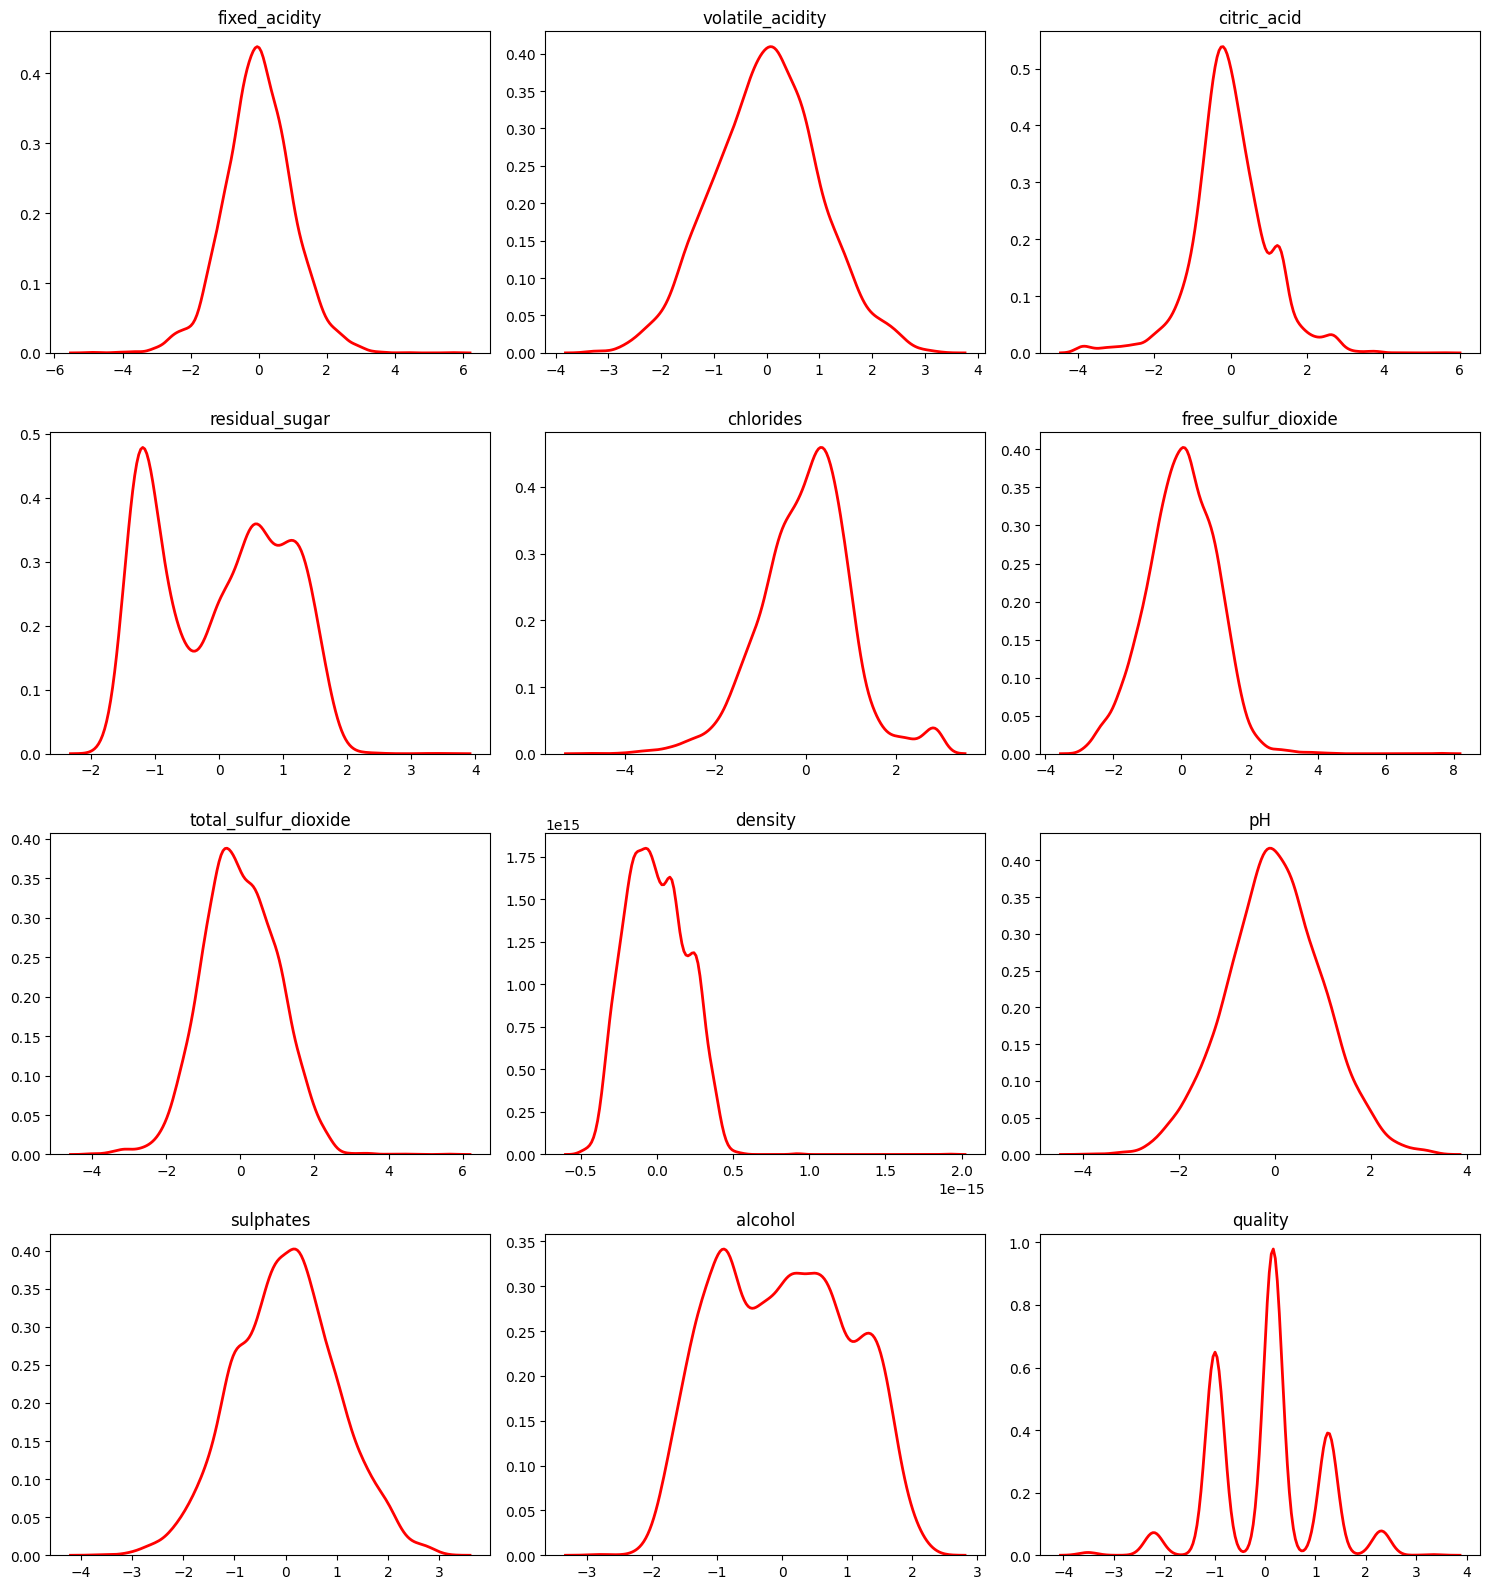

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import math


num_cols = df.select_dtypes(include="number").columns
pt = PowerTransformer(method="yeo-johnson")
df_transformed = pd.DataFrame(pt.fit_transform(df[num_cols]), columns=num_cols)

n_cols = 3  
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(df_transformed[col], color="red", linewidth=2)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


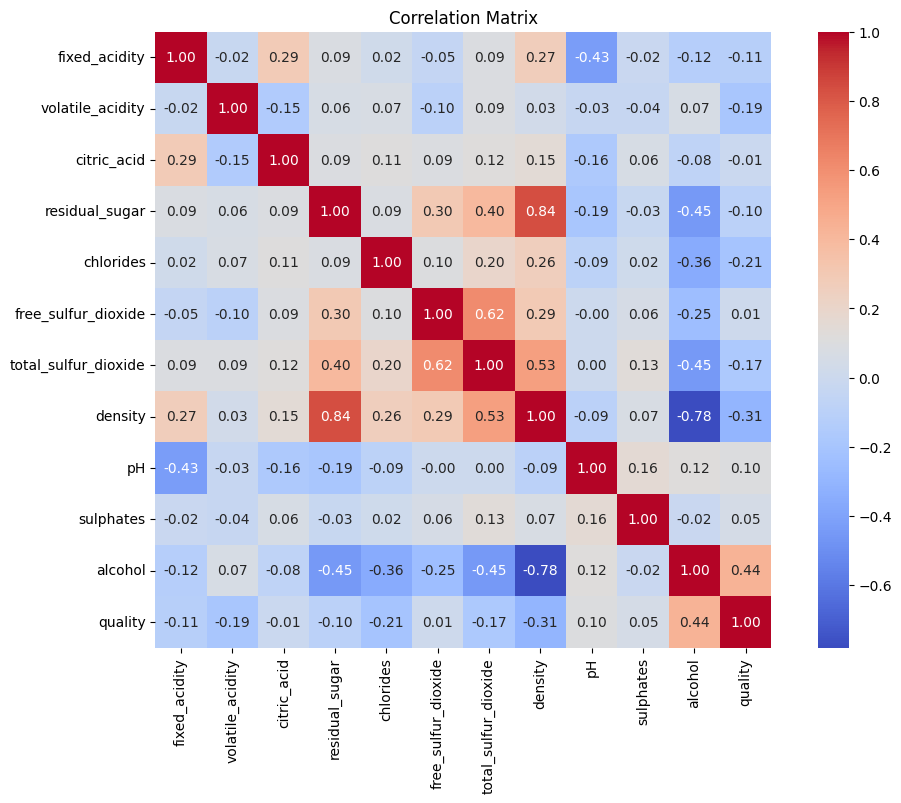

In [29]:
corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()


In [31]:
corr_matrix = df.corr().abs().unstack().sort_values(ascending=False)
corr_pairs = corr_matrix[(corr_matrix < 1)]

top_corr = corr_pairs.index[0]  
col_to_drop = top_corr[1]  

df_reduced = df.drop(columns=[col_to_drop])
print(f"Dropped column: {col_to_drop}")


Dropped column: density


In [33]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

df.drop(columns=to_drop, inplace=True)
print("Dropped columns:", to_drop)
print("Remaining columns:", df.columns.tolist())


Dropped columns: ['density']
Remaining columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol', 'quality']


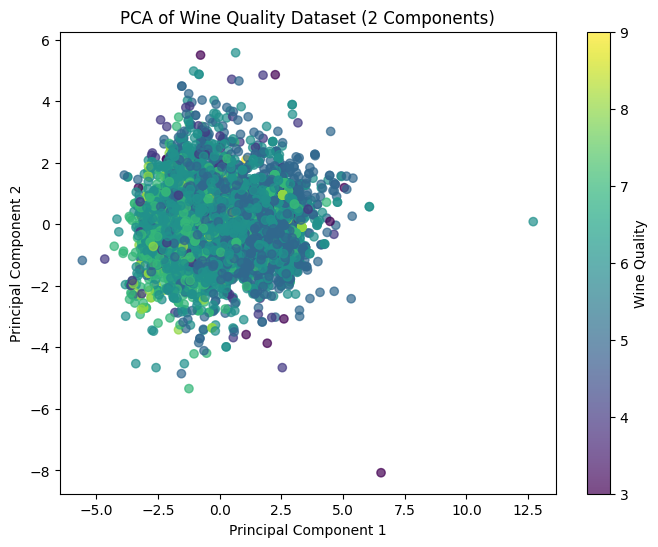

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv('winequality-red.csv')
X = df.drop('quality', axis=1)
y = df['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['quality'] = y.values

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['quality'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Wine Quality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Quality Dataset (2 Components)')
plt.show()


In [69]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib

df = pd.read_csv("winequality-red.csv")
df = df.drop(columns=["density"])
X = df.drop("quality", axis=1)
y = df["quality"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_scaled, y)

n_components = min(8, X_res.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_res)

processed_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
processed_df["quality"] = y_res
processed_df.to_csv("wine_processed_pca.csv", index=False)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res)

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
svc = SVC(random_state=42, probability=True)
dt = DecisionTreeClassifier(random_state=42)

rf_param = {"n_estimators": [100, 200], "max_depth": [None, 10]}
svc_param = {"C": [1, 10], "kernel": ["rbf"], "gamma": ["scale"]}
dt_param = {"max_depth": [None, 10], "min_samples_split": [2, 5]}

rs_rf = RandomizedSearchCV(rf, rf_param, n_iter=2, scoring="f1_macro", cv=2, random_state=42, n_jobs=-1, verbose=1)
rs_svc = RandomizedSearchCV(svc, svc_param, n_iter=2, scoring="f1_macro", cv=2, random_state=42, n_jobs=-1, verbose=1)
rs_dt = RandomizedSearchCV(dt, dt_param, n_iter=2, scoring="f1_macro", cv=2, random_state=42, n_jobs=-1, verbose=1)

rs_rf.fit(X_train, y_train)
rs_svc.fit(X_train, y_train)
rs_dt.fit(X_train, y_train)

models = {"RandomForest": rs_rf.best_estimator_, "SVM": rs_svc.best_estimator_, "DecisionTree": rs_dt.best_estimator_}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    results[name] = {"model": model, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

best_name = max(results.keys(), key=lambda k: results[k]["f1"])
best_model = results[best_name]["model"]

print("Results")
for k, v in results.items():
    print(k, v["accuracy"], v["precision"], v["recall"], v["f1"])

print("Best model by F1:", best_name)
print(classification_report(y_test, best_model.predict(X_test)))
print(confusion_matrix(y_test, best_model.predict(X_test)))

joblib.dump(best_model, "best_model.pkl")
joblib.dump({"scaler": scaler, "pca": pca, "feature_columns": list(X.columns)}, "preprocessing_artifacts.pkl")






Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Results
RandomForest 0.9135802469135802 0.9121834839634521 0.9136297074224181 0.9125248260994303
SVM 0.8044184535412605 0.7945716814307644 0.8045321421175636 0.7952094130259338
DecisionTree 0.8336582196231319 0.8340335633306607 0.8337314735378517 0.8337690032905795
Best model by F1: RandomForest
              precision    recall  f1-score   support

           3       0.99      0.99      0.99       439
           4       0.96      0.99      0.98       439
           5       0.82      0.86      0.84       440
           6       0.78      0.70      0.74       440
           7       0.85      0.86      0.86       440
           8       0.98      0.99      0.99       440
           9       1.00      1.00      1.00       440

    accuracy                           0.91      3078
   macro avg       0.91      0.91     

['preprocessing_artifacts.pkl']